# Digit recognition with CNN
## By Mohamed Farah
### Reference: https://www.tensorflow.org/tutorials/audio/simple_audio

In [233]:
!pip install -U -q tensorflow tensorflow_datasets pydub


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [234]:
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [235]:
DATASET_URL = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz"
DATASET_PATH = 'data/spoken_digit_dataset'
EXTRACT_PATH = 'data'

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    dataset_file_path = tf.keras.utils.get_file(
        'spoken_digit_dataset_v1.0.9.tar.gz',
        origin=DATASET_URL,
        extract=True,
        cache_dir='.',
        cache_subdir=EXTRACT_PATH
    )

    extracted_dir_path = pathlib.Path(dataset_file_path).parent / 'free-spoken-digit-dataset-1.0.9' / 'recordings'

    for digit in range(10):
        digit_dir = data_dir / str(digit)
        digit_dir.mkdir(parents=True, exist_ok=True)

        for wav_file in extracted_dir_path.glob(f'{digit}_*.wav'):
            shutil.move(str(wav_file), str(digit_dir / wav_file.name))

    shutil.rmtree(str(extracted_dir_path.parent))

print(f"Dataset is organized in: {data_dir}")

Dataset is organized in: data\spoken_digit_dataset


In [236]:
digits = np.array(tf.io.gfile.listdir(str(data_dir)))
digits = digits[(digits != 'README.md') & (digits != '.DS_Store')]
print('Digits:', digits)

Digits: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [237]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 2500 files belonging to 10 classes.
Using 2000 files for training.
Using 500 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [238]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [239]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [240]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 8000)
(64,)


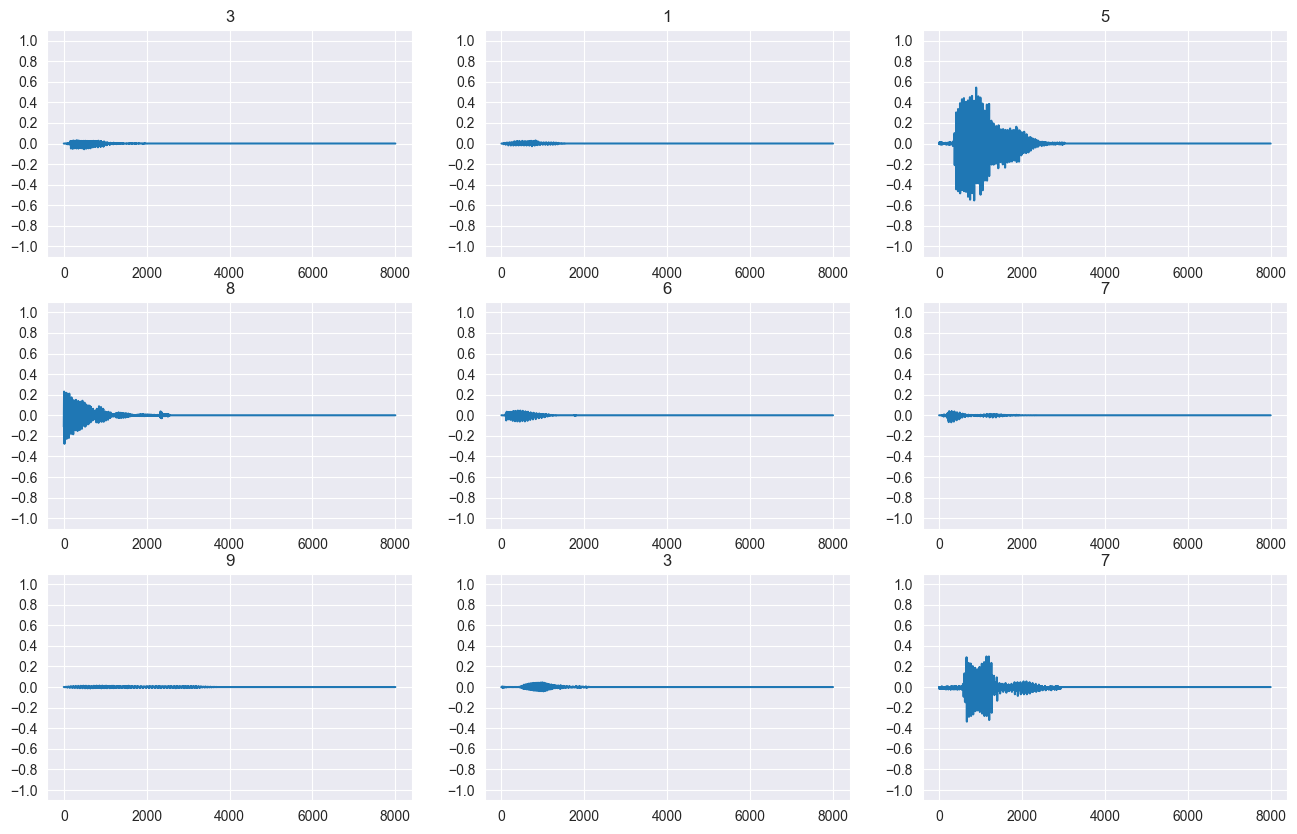

In [241]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [242]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [243]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=8000))

Label: 3
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 5
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


In [244]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

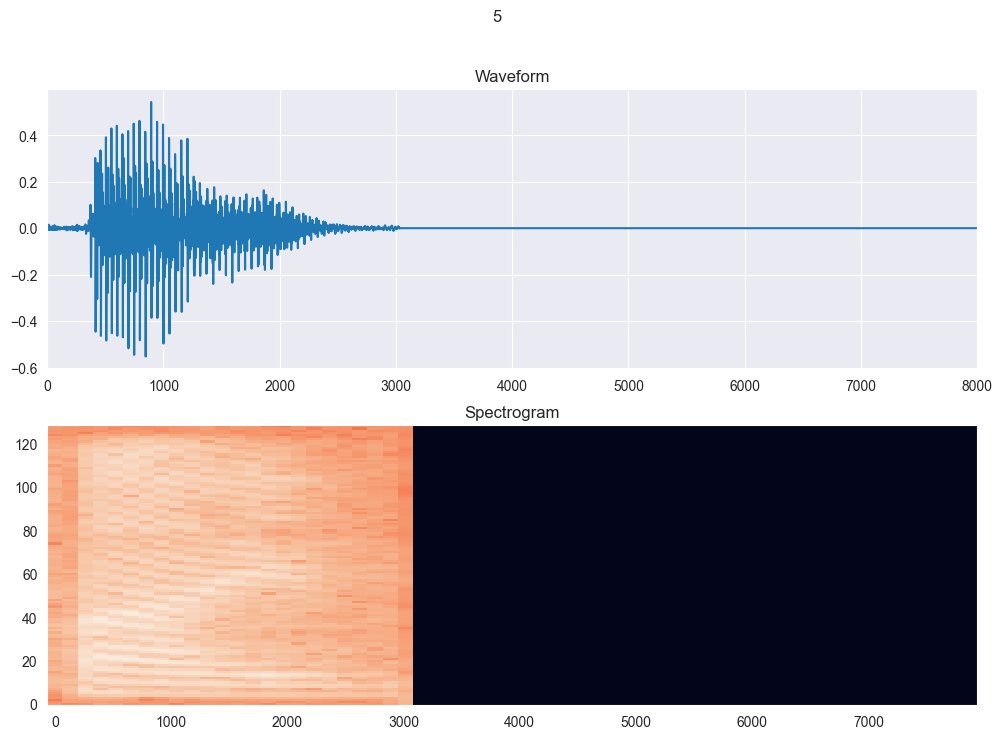

In [245]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [246]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [247]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [248]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

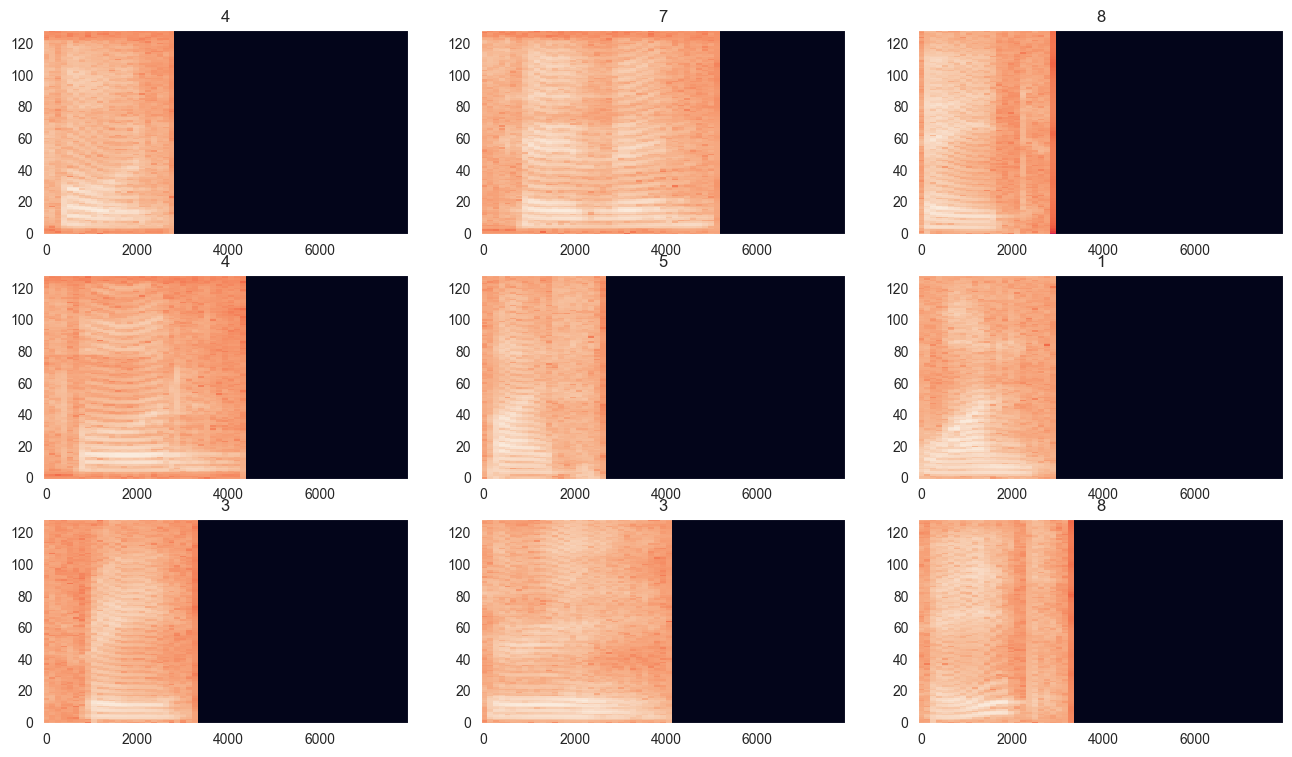

In [249]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [250]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [251]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_8 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_8 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 64)        640       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)       

In [252]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [253]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
32/32 [==============================] - 6s 177ms/step - loss: 2.6632 - accuracy: 0.2660 - val_loss: 2.3717 - val_accuracy: 0.3648
Epoch 2/20
32/32 [==============================] - 5s 165ms/step - loss: 2.1691 - accuracy: 0.4295 - val_loss: 1.9638 - val_accuracy: 0.4877
Epoch 3/20
32/32 [==============================] - 5s 167ms/step - loss: 1.8823 - accuracy: 0.5150 - val_loss: 1.7670 - val_accuracy: 0.5738
Epoch 4/20
32/32 [==============================] - 5s 167ms/step - loss: 1.6979 - accuracy: 0.5680 - val_loss: 1.6256 - val_accuracy: 0.6434
Epoch 5/20
32/32 [==============================] - 6s 177ms/step - loss: 1.5260 - accuracy: 0.6450 - val_loss: 1.4807 - val_accuracy: 0.6557
Epoch 6/20
32/32 [==============================] - 6s 201ms/step - loss: 1.4027 - accuracy: 0.6685 - val_loss: 1.4004 - val_accuracy: 0.6844
Epoch 7/20
32/32 [==============================] - 6s 183ms/step - loss: 1.3359 - accuracy: 0.7130 - val_loss: 1.2818 - val_accuracy: 0.7500
Epoch 

Text(0, 0.5, 'Accuracy [%]')

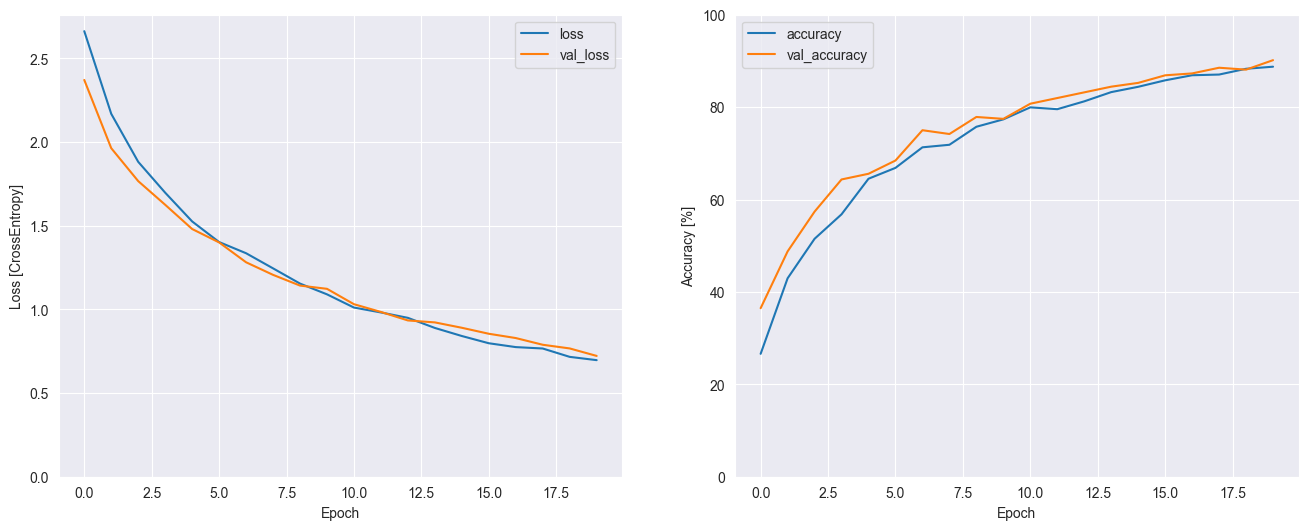

In [254]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [255]:
model.evaluate(test_spectrogram_ds, return_dict=True)

4/4 [==============================] - 0s 47ms/step - loss: 0.6410 - accuracy: 0.9219


{'loss': 0.6410393714904785, 'accuracy': 0.921875}

In [256]:
y_pred = model.predict(test_spectrogram_ds)

4/4 [==============================] - 0s 37ms/step


In [257]:
y_pred = tf.argmax(y_pred, axis=1)

In [258]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

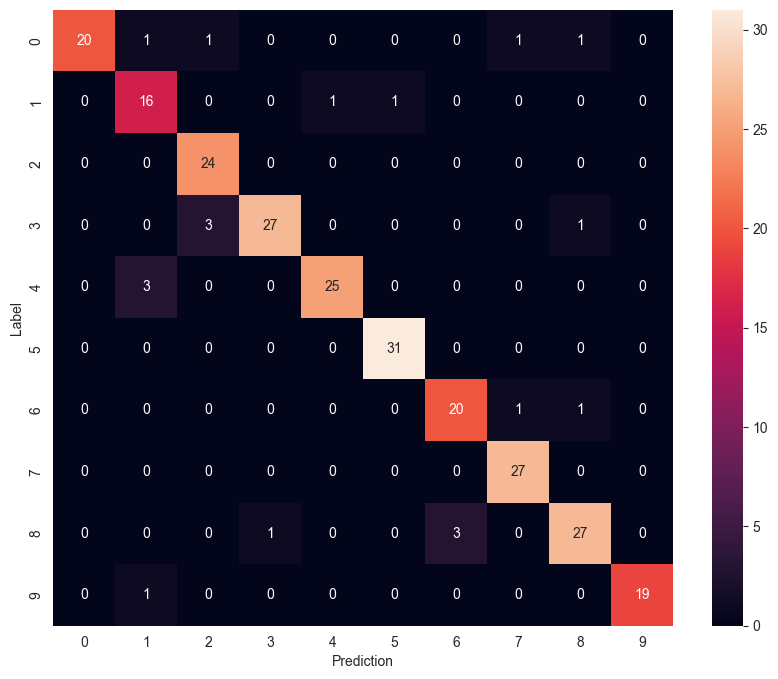

In [259]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Testing the model on random digits from https://huggingface.co/datasets/Voxlab/Synthetic-Spoken-Digit-Dataset/blob/main/digit_dataset.tar.gz

In [260]:
TEST_PATH = 'test'
test_dir = pathlib.Path(TEST_PATH)

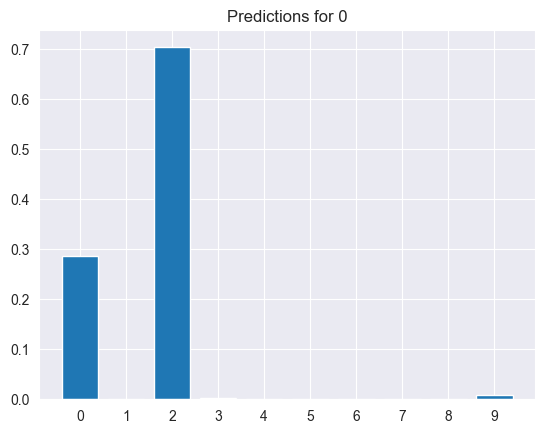

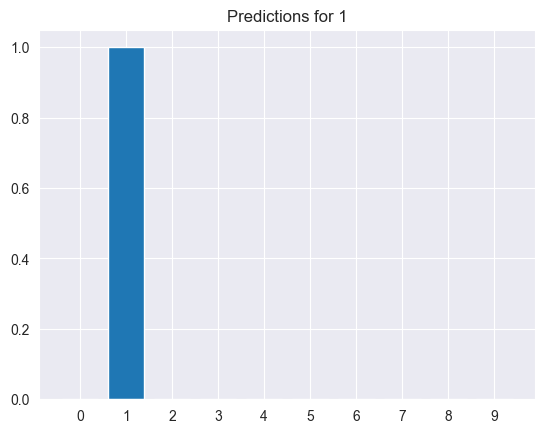

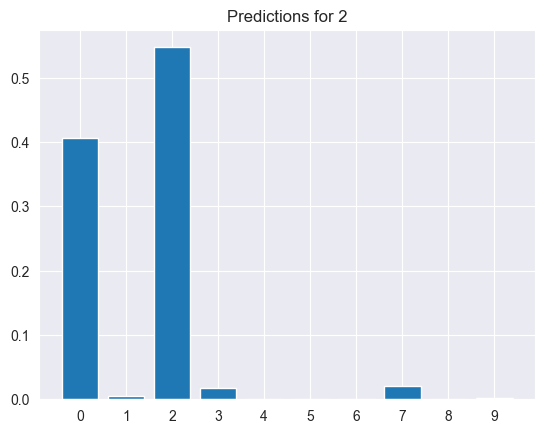

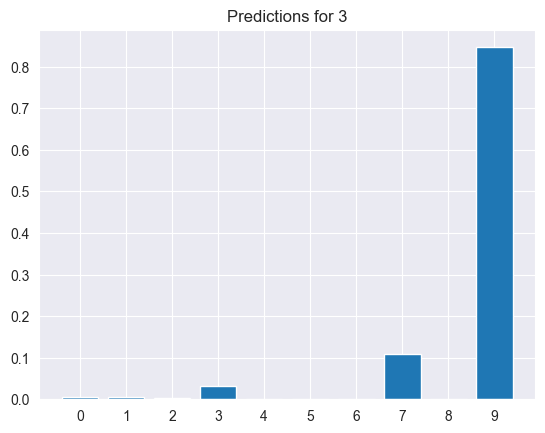

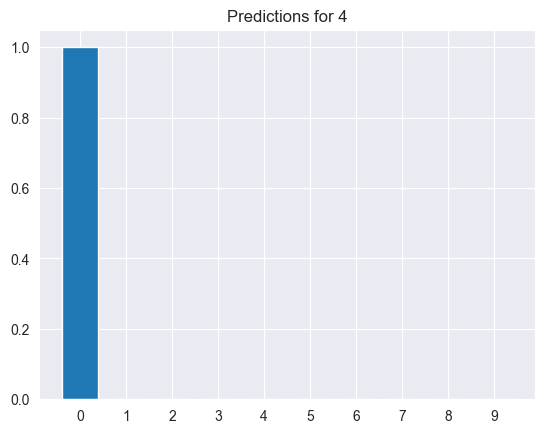

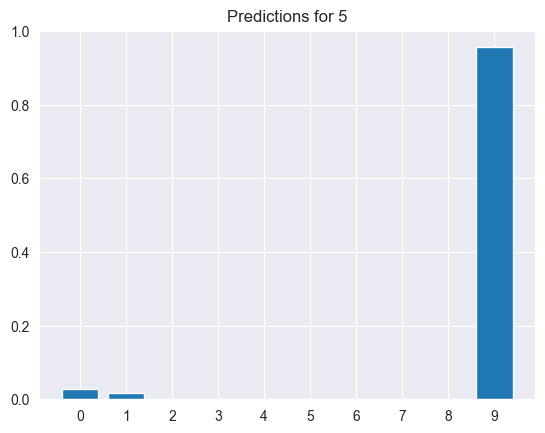

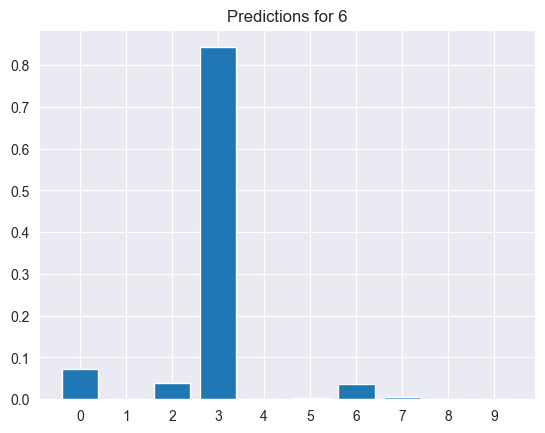

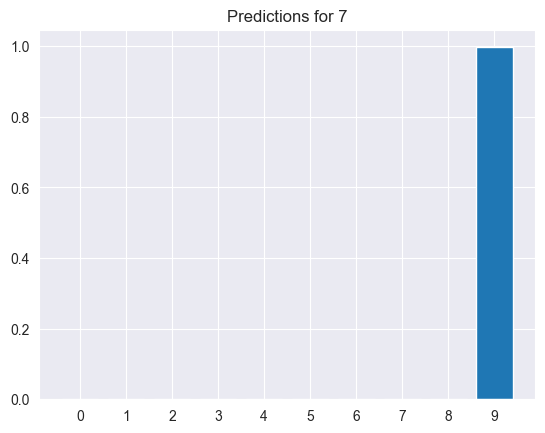

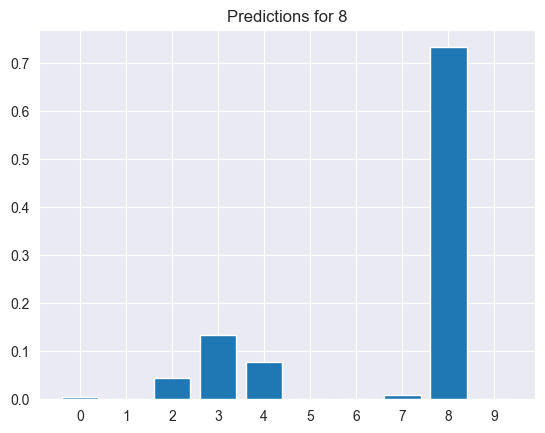

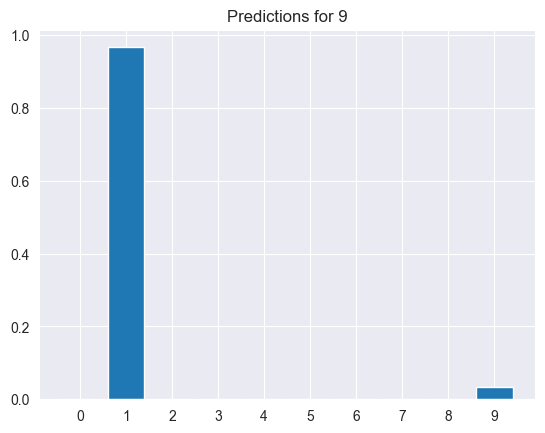

In [261]:
for digit in range(10):
    x = test_dir / (str(digit) + '.wav')
    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]

    prediction = model(x)
    x_labels = [str(i) for i in range(10)]
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for {digit}')
    plt.show()

    display.display(display.Audio(waveform, rate=8000))

We can see that only 3 out of 10 digits were correctly predicted. This is due to the fact that the model was trained on a different dataset than the one used for testing. The model needs to be trained on a larger dataset to be able to generalize better, and its parameters need to be tuned to improve its performance.